In [1]:
  import tensorflow as tf  
  import numpy as np
  import matplotlib.pyplot as plt

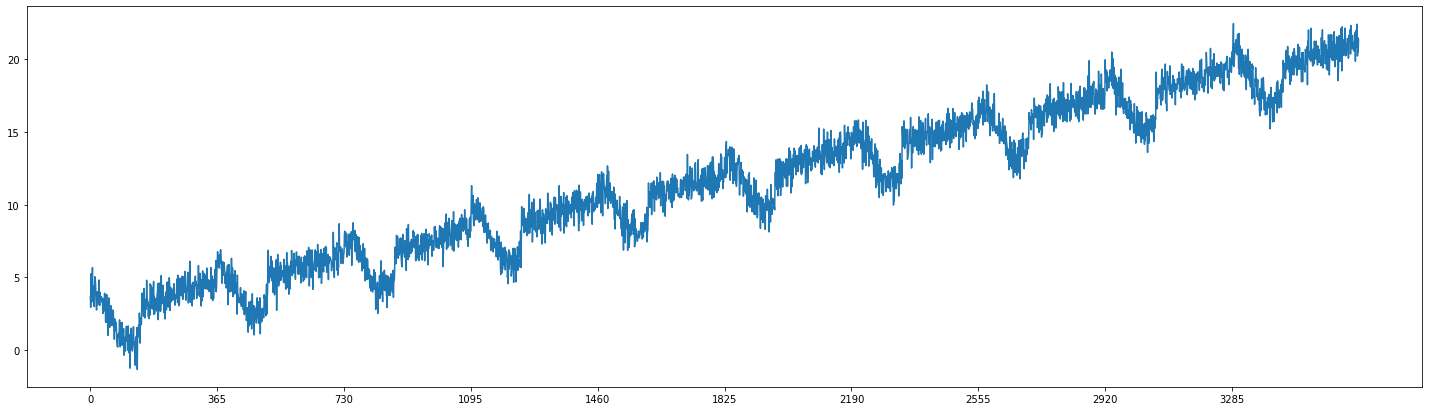

In [2]:
def trend(time, slope):
  return (time/200) * (1.0012**slope);

def seasonality(time, period):
  season = (time % period)/period
  return np.where(season < 0.4, 2*np.cos(10 * season), season)

def noise(time, noise_level, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.normal(size=len(time)) * noise_level

num_years = 10
period = 365
time = np.array(np.arange(period * num_years))
baseline = 2
slope = 0.1
noise_level = 0.7
series = baseline + seasonality(time, period) + trend(time, slope) + noise(time, noise_level)

plt.figure(figsize=(25,7))
plt.plot(series)
plt.xticks(period * np.arange(num_years))
plt.show()

In [ ]:
X = []
Y = []
window_size = 5
for i in range(len(series) - window_size):
  X.append(series[i: i + window_size])
  Y.append(series[i + window_size])

X = np.array(X)
Y = np.array(Y)

years_to_predict = 4
split_time = period * (num_years - years_to_predict)
X_train = X[:split_time]
Y_train = Y[:split_time]

X_val = X[split_time:]
Y_val = Y[split_time:]

## Autoregressive Model

In [ ]:
epochs = 200

model = tf.keras.Sequential([
  tf.keras.layers.Dense(window_size, activation='relu', input_shape=(window_size,)),
  tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics='mse')
model.summary()

history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.8)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14/14 [==============================] - 3s 22ms/step - loss: 0.6874 - mse: 1.7896 - val_loss: 1.3241 - val_mse: 4.3051
Epoch 2/200
14/14 [==============================] - 0s 7ms/step - loss: 0.5694 - mse: 1.4114 - val_loss: 0.8623 - val_mse: 2.4746
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 0.5057 - mse: 1.2312 - val_loss: 0.6103 - val_mse: 1.6093
Epoch 4/200
14/14 [==============================] - 0s 8ms/step - loss: 0.4777 - mse: 1.1559 - val_loss: 0.5226 - val_mse: 1.32

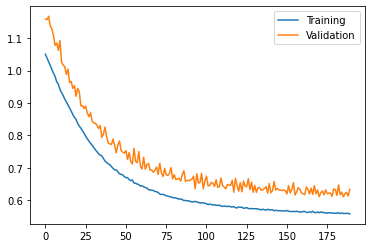

In [ ]:
plt.plot(history.history['mse'][10:], label="Training")
plt.plot(history.history['val_mse'][10:], label="Validation")
plt.legend()
plt.show()

In [ ]:
def plot_prediction(predictions, label="Model Prediction"):
  plt.figure(figsize=(20,7))
  plt.plot(Y_val, label="True Value")
  plt.plot(predictions, label=label)
  plt.legend()
  plt.show()

### One-Time Prediction

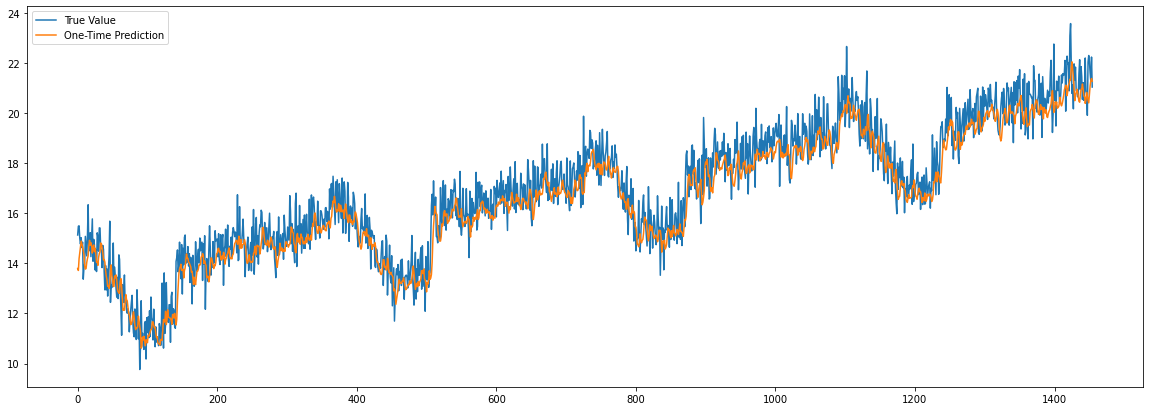

In [ ]:
predictions = []
predictions = model.predict(X_val)
predictions = np.array(predictions)

plot_prediction(predictions, "One-Time Prediction")

### Rolling Window Prediction

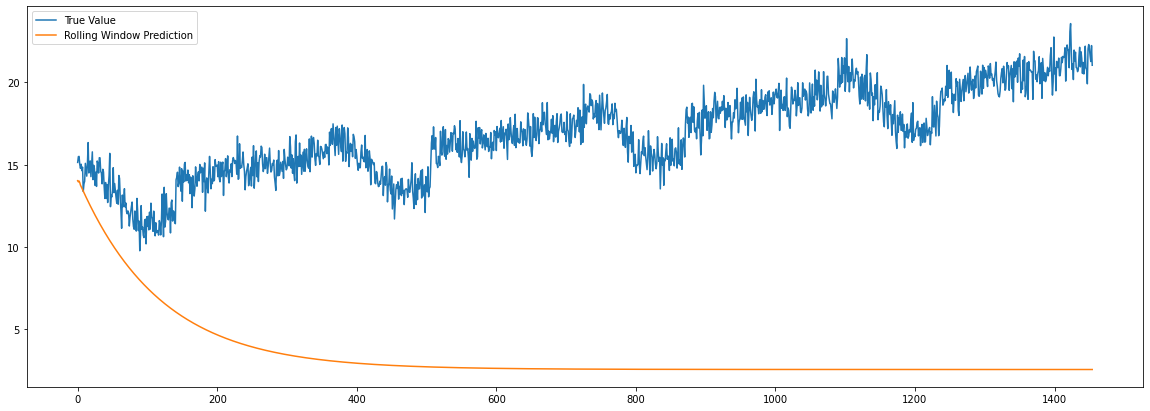

In [ ]:
predictions = []
window = X_train[-1].reshape((1, -1))
for i in np.arange(split_time, 365 * num_years - window_size):
  prediction = model.predict(window)[0,0]
  predictions.append(prediction)

  window = np.roll(window, shift=-1)
  window[0, -1] = prediction
predictions = np.array(predictions)

plot_prediction(predictions, "Rolling Window Prediction")

## SimpleRNN

In [ ]:
epochs = 200

model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(10, input_shape=(window_size,1)),
  tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.Huber(), 
              metrics='mse')
model.summary()

def trainSimpleRNN(model, X_train, Y_train):
  X_train = X_train.reshape((-1, window_size, 1))
  history = model.fit(X_train, Y_train, epochs=epochs, validation_split=0.8)

  return history

history = trainSimpleRNN(model, X_train, Y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14/14 [==============================] - 1s 28ms/step - loss: 3.1570 - mse: 15.7692 - val_loss: 8.3321 - val_mse: 86.4706
Epoch 2/200
14/14 [==============================] - 0s 19ms/step - loss: 2.8566 - mse: 13.4968 - val_loss: 8.0453 - val_mse: 81.5925
Epoch 3/200
14/14 [==============================] - 0s 14ms/step - loss: 2.5315 - mse: 11.1891 - val_loss: 7.7493 - val_mse: 76.7969
Epoch 4/200
14/14 [==============================] - 0s 17ms/step - loss: 2.1703 - mse: 8.8890 - val_loss: 7.4456 - 

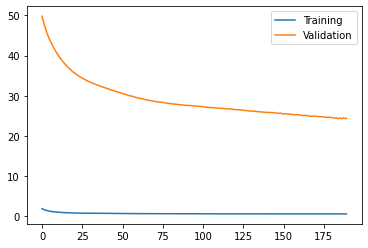

In [ ]:
plt.plot(history.history['mse'][10:], label="Training")
plt.plot(history.history['val_mse'][10:], label="Validation")
plt.legend()
plt.show()

### One-Time Prediction

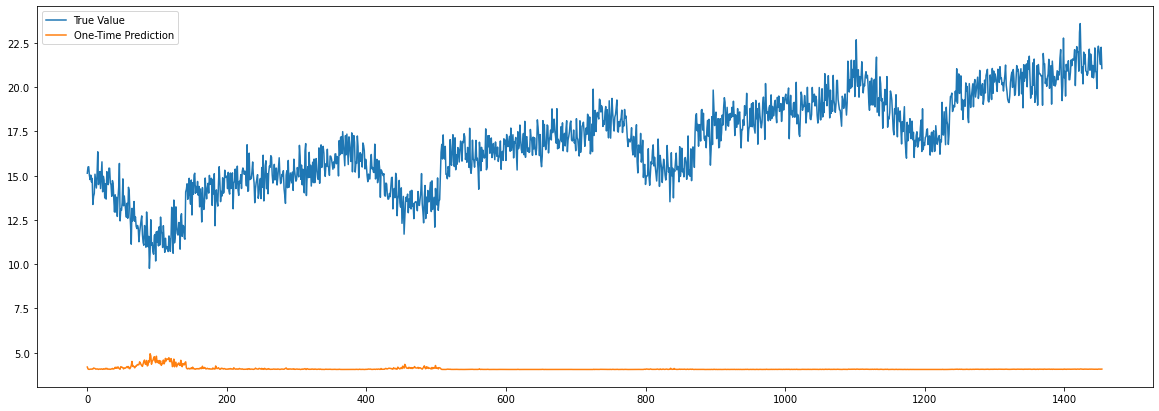

In [ ]:
predictions = []
X_val_prime = X_val.reshape((-1, 1, window_size, 1))

for feature in X_val_prime:
  prediction = model.predict(feature)[0,0]
  predictions.append(prediction)
  
plot_prediction(predictions, "One-Time Prediction")

### Rolling Window Prediction

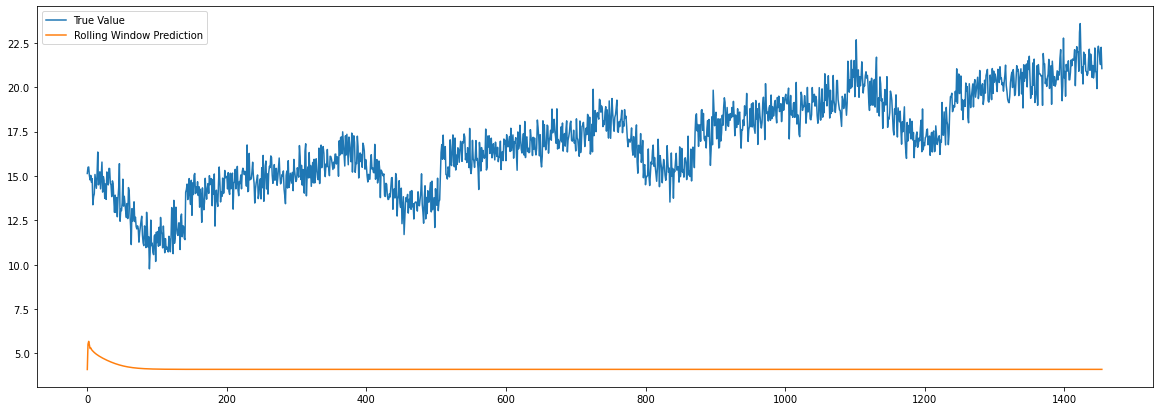

In [ ]:
predictions = []

X_val_prime = X_val.reshape((-1, 1, window_size, 1))
window = X_train[-1].reshape(1, window_size, 1)
for feature in X_val_prime:
  prediction = model.predict(window)[0,0]
  predictions.append(prediction)

  window = np.roll(window, shift=-1)
  window[0,-1,0] = prediction
  
plot_prediction(predictions, "Rolling Window Prediction")

## GRU

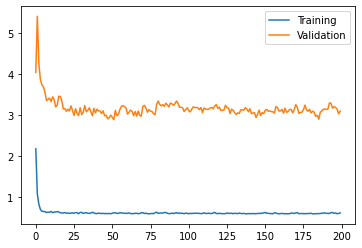

In [ ]:
def train_GRU(x_train, y_train):
  epochs=200
  model = tf.keras.Sequential([
    tf.keras.layers.GRU(10, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.GRU(20),
    tf.keras.layers.Dense(1)                       
  ])

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.01, momentum=0.9),
                loss=tf.keras.losses.Huber(), 
                metrics='mae')
  
  x_train = x_train.reshape((-1, window_size, 1))
  history = model.fit(x_train, y_train, epochs=epochs, verbose=False,
                      validation_split=0.8)
  return (model,history)

model, history = train_GRU(X_train, Y_train)
plt.plot(history.history['mae'], label="Training")
plt.plot(history.history['val_mae'], label="Validation")
plt.legend()
plt.show()

### One-Time Prediction

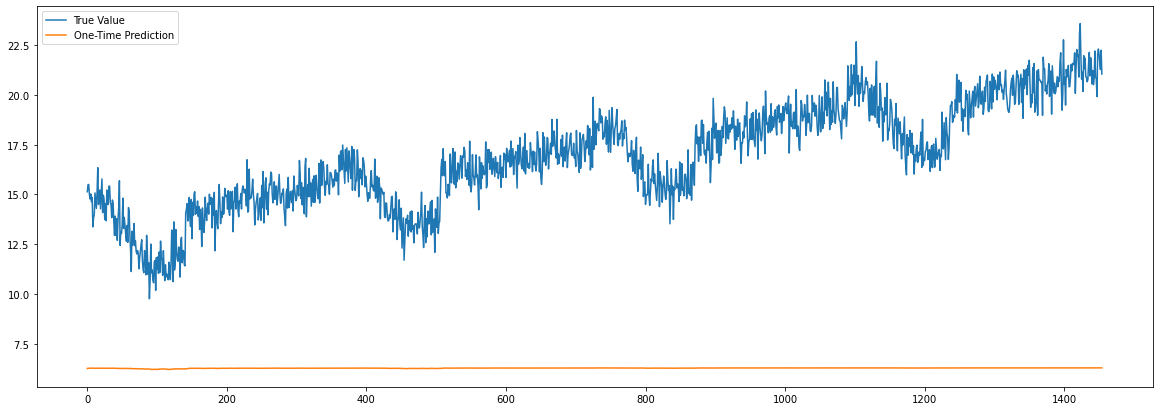

In [ ]:
predictions = []
for features in X_val:
  prediction = model.predict(features.reshape(1, -1, 1))[0,0]
  predictions.append(prediction)

plot_prediction(predictions, "One-Time Prediction")

### Rolling Window Prediction

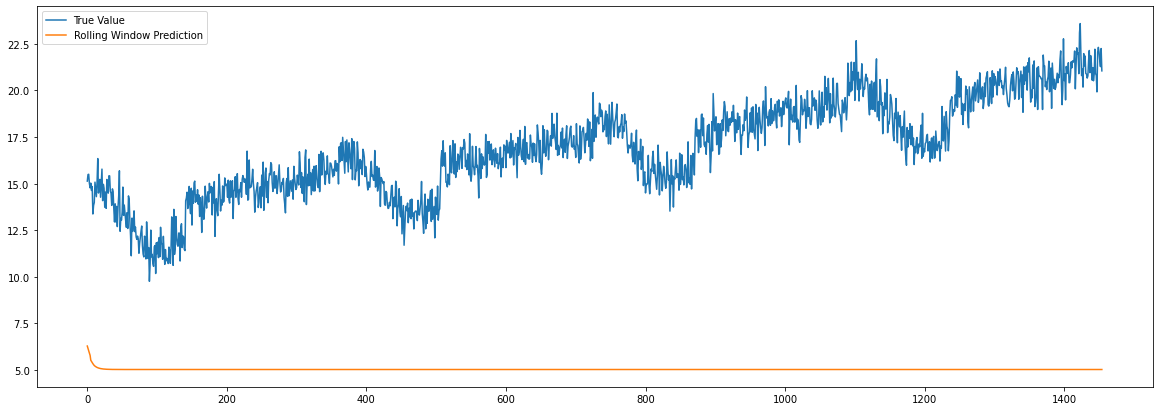

In [ ]:
predictions = []

window = X_val[-1]
for i in range(len(Y_val)):
  prediction = model.predict(window.reshape(1, -1, 1))[0,0]
  predictions.append(prediction)
  
  # print(window)
  window = np.roll(window, shift=-1)
  window[-1] = prediction

plot_prediction(predictions, "Rolling Window Prediction")

## LSTM

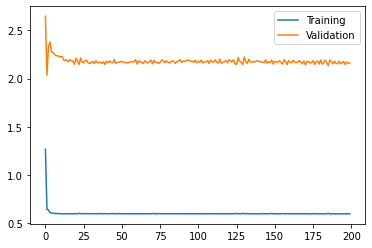

In [ ]:
def train_LSTM(X_train, Y_train):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.LSTM(10, input_shape=(window_size, 1)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: 25*x)
  ])

  optimizer = optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.Huber(),
                metrics = 'mae')
  
  X_train = X_train.reshape((-1, window_size, 1))
  Y_train = Y_train.reshape((-1, 1))
  epochs = 200
  history = model.fit(X_train, Y_train, validation_split=0.8, 
                      verbose=False, epochs=epochs)
  
  return (model, history)


model, history = train_LSTM(X_train, Y_train)
plt.plot(history.history['mae'], label="Training")
plt.plot(history.history['val_mae'], label="Validation")
plt.legend()
plt.show()

### One-Time Prediction

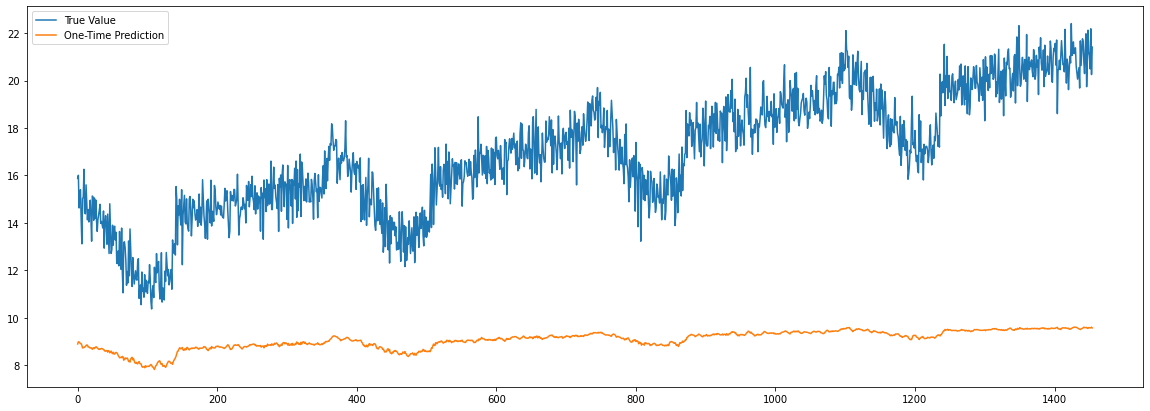

In [ ]:
predictions = []
predictions = model.predict(X_val.reshape((-1, window_size, 1)))
X_val.reshape((-1, window_size, 1)).shape
plot_prediction(predictions, label="One-Time Prediction")